In [117]:
import numpy as np
from matplotlib import pyplot as plt

loaded = np.load("/data/dust/user/dayhallh/point-cloud-diffusion-data/showerFlow/sampling/pureShowerflow_sim-E1261AT600AP180-180_alt1_nb2_inputs8070450532247928831_fnorms_dhist_best_2025-06-26_big_wnoise.npz")

In [118]:
loaded = dict(loaded)
for key in loaded:
    print(f"{key}; {loaded[key].shape}")

showerflow_out; (100000, 62)
showerflow_noise; (100000, 62)
cond; (100000, 4)
showerflow_unrelated; (100000, 62)


In [76]:
n=10_000

incidents = loaded['cond'][:n, 0]
cog_x = loaded['showerflow_out'][:n, 0]
cog_y = loaded['showerflow_out'][:n, 1]
max_abs_cog =  np.maximum(np.abs(cog_x), np.abs(cog_y))
energies = loaded['showerflow_out'][:n, -30:]
unrelated_energies = loaded['showerflow_unrelated'][:n, -30:]
max_abs_energy = np.max(np.abs(energies), axis=1)
min_energy = np.min(energies, axis=1)
sum_energies = np.sum(np.clip(energies, None, 0), axis=1)
noise = loaded['showerflow_noise'][:n]


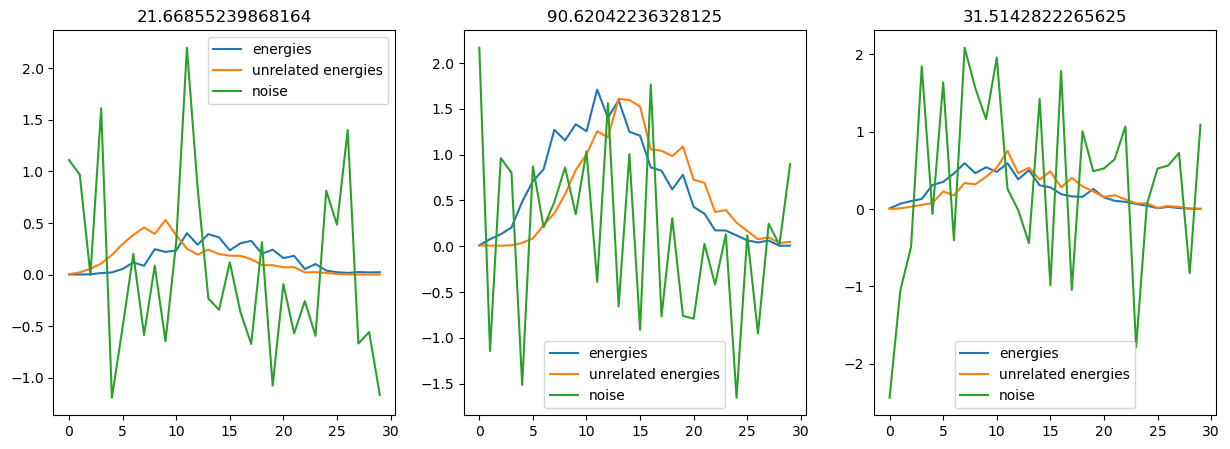

In [74]:
n_events = 3
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

for i in range(n_events):

    axarr[i].plot(range(30), energies[i], label='energies')
    axarr[i].plot(range(30), unrelated_energies[i], label='unrelated energies')
    axarr[i].plot(range(30), noise[i][-30:], label='noise')
    axarr[i].set_title(f"{incidents[i]*127}")
    axarr[i].legend()

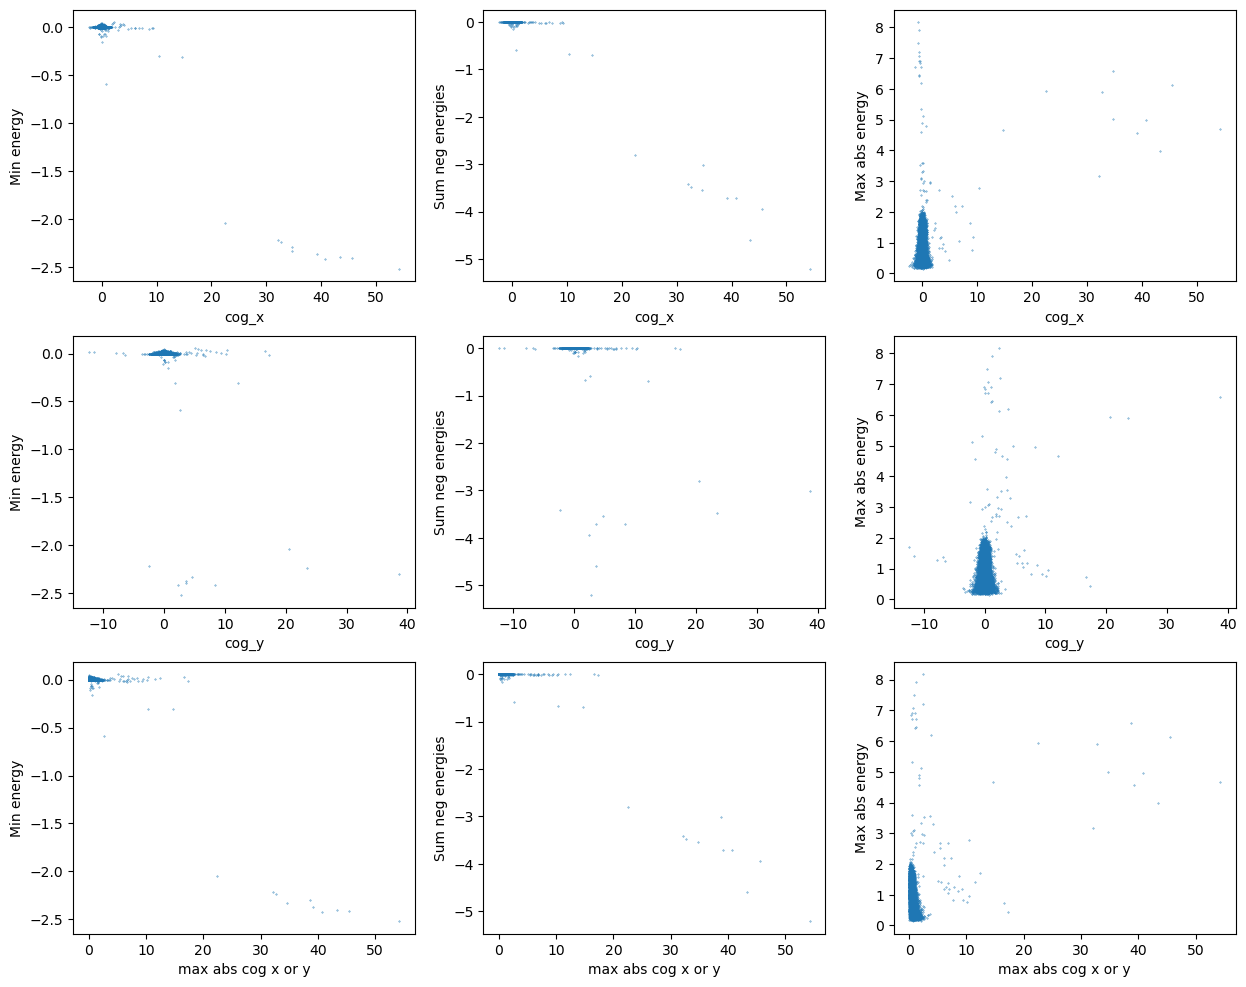

In [77]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 12))
scatter_kwgs = {'s':0.1}
for ix, x_label in enumerate(["cog_x", "cog_y", "max abs cog x or y"]):
    if ix==0:
        x = cog_x
    elif ix == 2:
        x = max_abs_cog
    else:
        x = cog_y
    axarr[ix, 0].scatter(x, min_energy, **scatter_kwgs)
    axarr[ix, 0].set_ylabel("Min energy")
    axarr[ix, 1].scatter(x, sum_energies, **scatter_kwgs)
    axarr[ix, 1].set_ylabel("Sum neg energies")
    axarr[ix, 2].scatter(x, max_abs_energy, **scatter_kwgs)
    axarr[ix, 2].set_ylabel("Max abs energy")
    for ax in axarr[ix]:
        ax.set_xlabel(x_label)

    

In [80]:
import scipy
from tqdm import tqdm
spearman = []
for predicted in [cog_x, cog_y, max_abs_cog]:
    spearman.append([])
    for predictor in tqdm(noise.T):
        spearman[-1].append(scipy.stats.spearmanr(predicted, predictor).statistic)
spearman = np.array(spearman)

100%|██████████| 62/62 [00:00<00:00, 930.29it/s]


In [96]:
import scipy
from tqdm import tqdm
spearman_problems = []
for predicted in [cog_x, cog_y, max_abs_cog]:
    mask = np.abs(predicted)>4
    predicted = predicted[mask]
    spearman_problems.append([])
    for predictor in tqdm(noise[mask].T):
        
        spearman_problems[-1].append(scipy.stats.spearmanr(predicted, predictor).statistic)
spearman = np.array(spearman)

100%|██████████| 62/62 [00:00<00:00, 3367.61it/s]


Text(0, 0.5, 'Spearman rank, only |CoG| > 4')

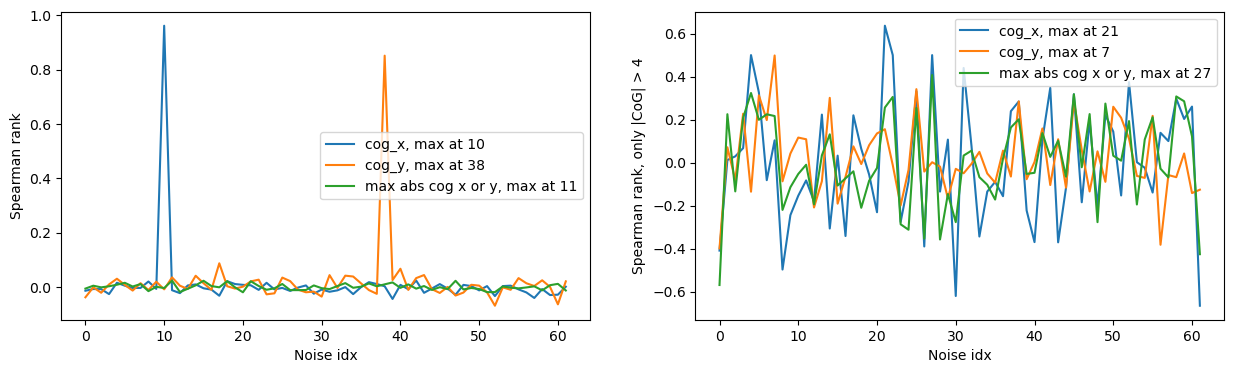

In [99]:
fig, axarr = plt.subplots(1, 2, figsize=(15, 4))


for ix, x_label in enumerate(["cog_x", "cog_y", "max abs cog x or y"]):
    label = f"{x_label}, max at {np.argmax(spearman[ix])}"
    axarr[0].plot(spearman[ix], label=label)
    label = f"{x_label}, max at {np.argmax(spearman_problems[ix])}"
    axarr[1].plot(spearman_problems[ix], label=label)
axarr[1].legend()    
axarr[0].legend()

axarr[0].set_xlabel("Noise idx")
axarr[1].set_xlabel("Noise idx")
axarr[0].set_ylabel("Spearman rank")
axarr[1].set_ylabel("Spearman rank, only |CoG| > 4")

[ 675 1946 2047 7558]


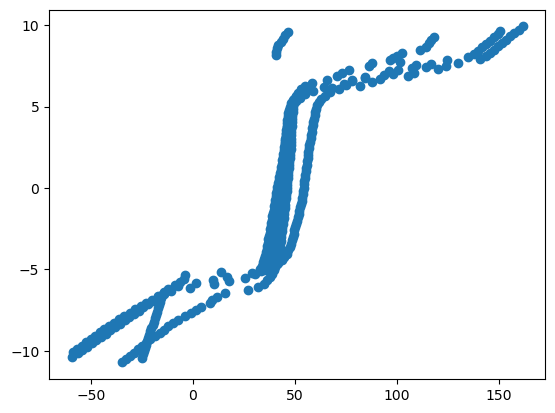

In [125]:
idx_problem = np.where(cog_x > 40)[0]
print(idx_problem)
noise_problem = noise[idx_problem]
conditioning_problem = loaded['cond'][idx_problem]
new_noise = []
new_cond = []
for c, n in zip(conditioning_problem, noise_problem):
    for shift in np.linspace(-10, 10, 100):
        shift_vec = np.zeros(62)
        shift_vec[10] = shift
        new_noise.append(shift_vec + n)
        new_cond.append(c)

np.savez("/data/dust/user/dayhallh/data/try_noise.npz", noise=new_noise, cond=new_cond)
    
loaded3 = np.load("/data/dust/user/dayhallh/data/shifted_noise_problem.npz")
cog_x3 = loaded3["showerflow_out"][:, 0]
cog_y3 = loaded3["showerflow_out"][:, 1]
noise3 = loaded3['showerflow_noise']

plt.scatter(cog_x3, noise3[:, 10])
#plt.xlim(40, 55)

Text(0, 0.5, '')

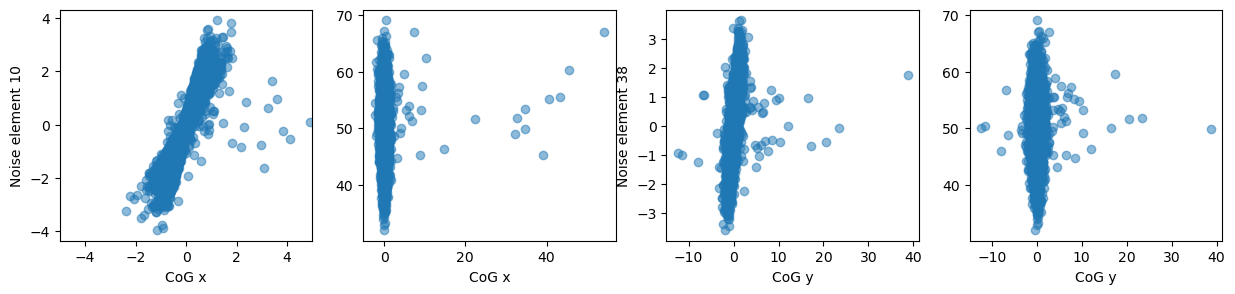

In [122]:
fig, axarr = plt.subplots(1, 4, figsize=(15, 3))

scatter_kws = {'alpha':0.5}
axarr[0].scatter(cog_x, noise[:, 10], **scatter_kws)
axarr[0].set_xlabel("CoG x")
axarr[0].set_ylabel("Noise element 10")
axarr[0].set_xlim(-5, 5)
axarr[2].scatter(cog_y, noise[:, 38], **scatter_kws)
axarr[2].set_xlabel("CoG y")
axarr[2].set_ylabel("Noise element 38")
mag_noise = np.sum(np.abs(noise), axis=1)
label=""
axarr[1].scatter(cog_x, mag_noise, **scatter_kws)
axarr[1].set_xlabel("CoG x")
axarr[1].set_ylabel(label)
axarr[3].scatter(cog_y, mag_noise, **scatter_kws)
axarr[3].set_xlabel("CoG y")
axarr[3].set_ylabel(label)